# histolab data qc

In [2]:
import os
data_path = '/lab/deasylab3/Jung/tiger/'
dir_TIFF_images = data_path + "/wsirois/wsi-level-annotations/images/"


imgs_names = os.listdir(dir_TIFF_images)
imgs_names.sort()

imgs_names = [i for i in imgs_names if i.startswith('TCGA')]    


In [3]:
import histolab

In [4]:
from PIL import Image
from histolab.filters.image_filters import (
    ApplyMaskImage,
    Compose,
    OtsuThreshold,
    RgbToGrayscale,
)
from histolab.filters.morphological_filters import BinaryDilation

def composed_filters(image_rgb):
    filters = Compose(
        [
            RgbToGrayscale(),
            OtsuThreshold(),
            BinaryDilation(),
            ApplyMaskImage(image_rgb),
        ]
    )
    return filters(image_rgb)

In [5]:
wsi_path = dir_TIFF_images + imgs_names[0]

In [6]:
wsi_path

'/lab/deasylab3/Jung/tiger//wsirois/wsi-level-annotations/images/TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297.tif'

In [7]:
from histolab.slide import Slide

In [8]:
import numpy as np
from histolab.slide import Slide
from histolab.masks import BinaryMask
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

class TissueMask(BinaryMask):
    def _mask(self, slide):
        # Read the thumbnail for quick mask estimation
        thumbnail = slide.thumbnail  # small RGB image
        gray = rgb2gray(thumbnail)  # convert to grayscale [0, 1]
        
        # Threshold using Otsu’s method
        thresh = threshold_otsu(gray)
        tissue_mask_thumb = gray < thresh  # tissue is usually darker

        # Resize mask to match slide dimensions
        from skimage.transform import resize
        full_mask = resize(
            tissue_mask_thumb.astype(np.uint8),
            slide.dimensions[::-1],  # (height, width)
            order=0, preserve_range=True, anti_aliasing=False
        ).astype(np.uint8)

        return full_mask



In [9]:
slide = Slide(wsi_path, processed_path="processed")

# Apply tissue mask
mask = TissueMask()
mask_array = mask(slide)

In [10]:
import matplotlib.pyplot as plt

import numpy as np
from skimage.transform import resize

# Convert thumbnail to NumPy array
thumbnail = np.array(slide.thumbnail)

# Resize the binary mask to match thumbnail shape (height, width)
mask_resized = resize(
    mask_array,
    output_shape=thumbnail.shape[:2],  # (height, width)
    order=0,
    preserve_range=True,
    anti_aliasing=False
).astype(bool)


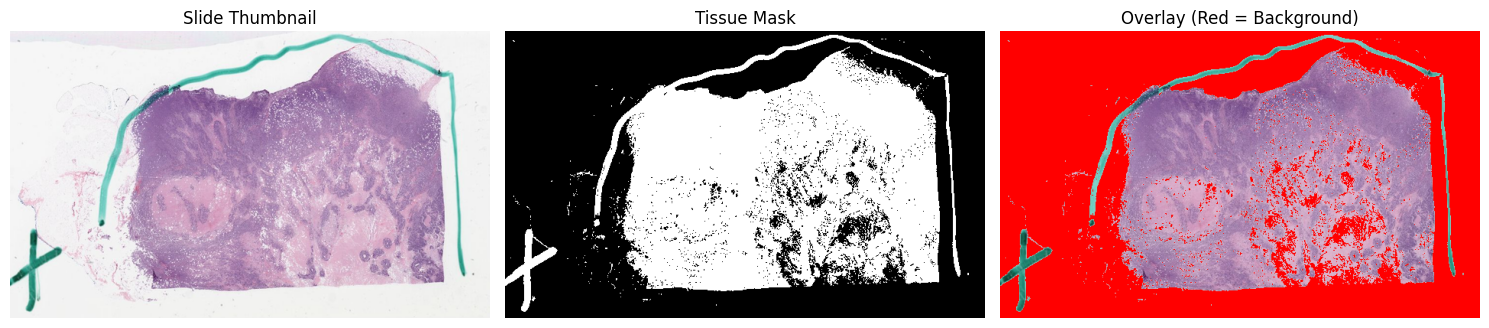

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original thumbnail
axes[0].imshow(thumbnail)
axes[0].set_title("Slide Thumbnail")
axes[0].axis("off")

# Mask only
axes[1].imshow(mask_resized, cmap="gray")
axes[1].set_title("Tissue Mask")
axes[1].axis("off")

# Overlay: red mask over thumbnail
overlay = thumbnail.copy()
overlay[~mask_resized] = [255, 0, 0]  # red background for non-tissue

axes[2].imshow(overlay)
axes[2].set_title("Overlay (Red = Background)")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [12]:
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import binary_dilation, remove_small_holes, remove_small_objects, disk
from histolab.masks import BinaryMask

class CustomTissueMask(BinaryMask):
    def _mask(self, slide):
        # Step 1: Get thumbnail and convert to grayscale
        thumb_rgb = np.array(slide.thumbnail)
        gray = rgb2gray(thumb_rgb)

        # Step 2: Otsu threshold
        thresh = threshold_otsu(gray)
        binary = gray < thresh  # darker = tissue

        # Step 3: Binary dilation
        dilated = binary_dilation(binary, selem=disk(3))

        # Step 4: Remove small holes
        no_holes = remove_small_holes(dilated, area_threshold=500)

        # Step 5: Remove small objects
        cleaned = remove_small_objects(no_holes, min_size=1000)

        # Step 6: Resize to full-resolution dimensions
        from skimage.transform import resize
        resized_mask = resize(
            cleaned.astype(np.uint8),
            slide.dimensions[::-1],  # (height, width)
            order=0, preserve_range=True, anti_aliasing=False
        ).astype(np.uint8)

        # Step 7: Return final binary mask
        return resized_mask


In [13]:
mask = CustomTissueMask()
final_mask = mask(slide)

/tmp/ipykernel_4132180/2760142076.py:18: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  dilated = binary_dilation(binary, selem=disk(3))


In [14]:
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label
import numpy as np

# Get slide thumbnail and convert to array
thumbnail = np.array(slide.thumbnail)

# Resize mask to thumbnail size
from skimage.transform import resize
mask_resized = resize(
    final_mask,
    thumbnail.shape[:2],  # (height, width)
    order=0,
    preserve_range=True,
    anti_aliasing=False
).astype(bool)

# Optional: Bounding box of largest tissue region
labeled = label(mask_resized)
props = regionprops(labeled)
if props:
    largest_region = max(props, key=lambda x: x.area)
    minr, minc, maxr, maxc = largest_region.bbox
else:
    minr = minc = maxr = maxc = 0


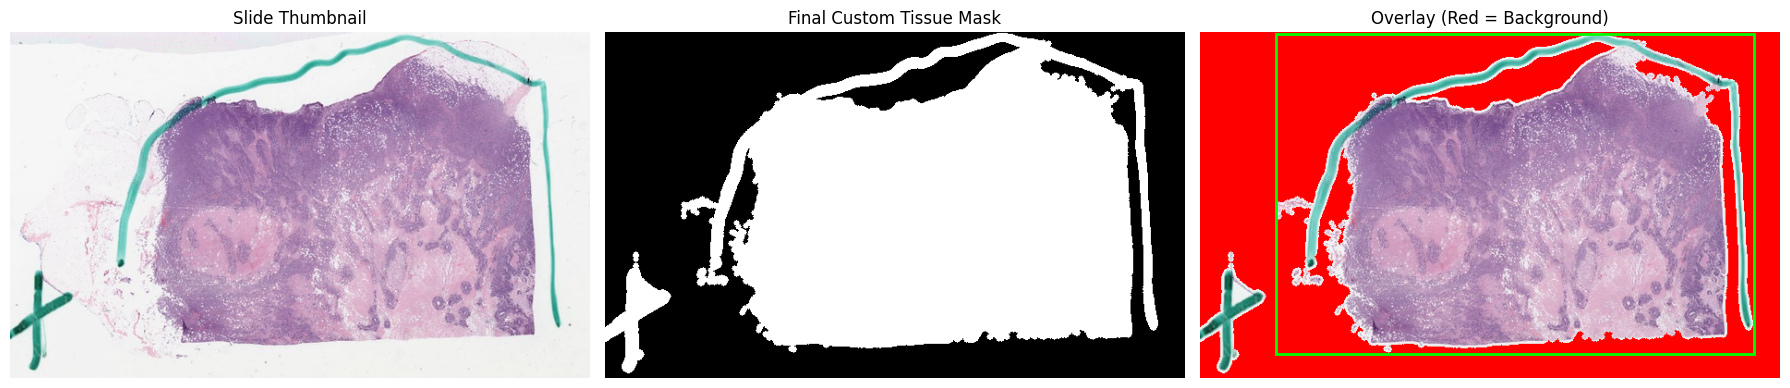

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Slide thumbnail
axes[0].imshow(thumbnail)
axes[0].set_title("Slide Thumbnail")
axes[0].axis("off")

# Final binary mask
axes[1].imshow(mask_resized, cmap="gray")
axes[1].set_title("Final Custom Tissue Mask")
axes[1].axis("off")

# Overlay
overlay = thumbnail.copy()
overlay[~mask_resized] = [255, 0, 0]  # red background
axes[2].imshow(overlay)
axes[2].set_title("Overlay (Red = Background)")
axes[2].axis("off")

# Optional: Draw bounding box on overlay
if maxr > minr and maxc > minc:
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                         edgecolor='lime', facecolor='none', linewidth=2)
    axes[2].add_patch(rect)

plt.tight_layout()
plt.show()


In [17]:
from PIL import Image

# Step 1: Get full-resolution slide dimensions
W, H = slide.dimensions  # (width, height)

# Step 2: Convert thumbnail to NumPy and calculate scale
thumbnail = np.array(slide.thumbnail)
thumb_h, thumb_w = thumbnail.shape[:2]

scale_x = W / thumb_w
scale_y = H / thumb_h

# Step 3: Scale bounding box coords from thumbnail to slide
x_min = int(minc * scale_x)
y_min = int(minr * scale_y)
x_max = int(maxc * scale_x)
y_max = int(maxr * scale_y)

# Step 4: Extract ROI using OpenSlide directly
roi_pil = slide._wsi.read_region(
    location=(x_min, y_min),
    level=2,
    size=(x_max - x_min, y_max - y_min)
).convert("RGB")  # Remove alpha

# Step 5: Show or save
#roi_pil.show()  # Open in default viewer
roi_pil.save("roi_tissue_box.tif")  # Optional save


error: 'L' format requires 0 <= number <= 4294967295

In [18]:
from PIL import Image

# Step 1: Get full-resolution slide dimensions
W, H = slide.dimensions  # (width, height)

# Step 2: Convert thumbnail to NumPy and calculate scale
thumbnail = np.array(slide.thumbnail)
thumb_h, thumb_w = thumbnail.shape[:2]

scale_x = W / thumb_w
scale_y = H / thumb_h

# Step 3: Scale bounding box coords from thumbnail to slide
x_min = int(minc * scale_x)
y_min = int(minr * scale_y)
x_max = int(maxc * scale_x)
y_max = int(maxr * scale_y)

# Step 4: Adjust coordinates for level=2
level = 2
downsample = slide._wsi.level_downsamples[level]

# Scale down location and size
x_min_level = int(x_min / downsample)
y_min_level = int(y_min / downsample)
width_level = int((x_max - x_min) / downsample)
height_level = int((y_max - y_min) / downsample)

# Step 5: Read the region at level 2
roi_pil = slide._wsi.read_region(
    location=(x_min_level, y_min_level),
    level=level,
    size=(width_level, height_level)
).convert("RGB")

# Step 6: Save the cropped region
roi_pil.save("roi_tissue_box.tif")


/cluster/home/srivash/miniforge3/envs/histolab/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (112034520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


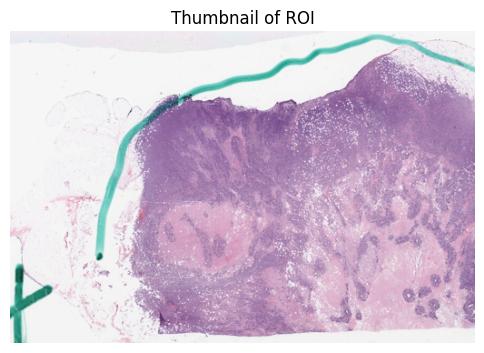

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the full .tif image
img = Image.open("roi_tissue_box.tif")

# Create a thumbnail (in-place) - this doesn't modify the original image
thumbnail_size = (512, 512)  # or any small size you want
img.thumbnail(thumbnail_size)

# Show the thumbnail using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Thumbnail of ROI")
plt.show()


In [20]:
slide = Slide("roi_tissue_box.tif", processed_path="processed")

In [21]:
thumbnail = np.array(slide.thumbnail)

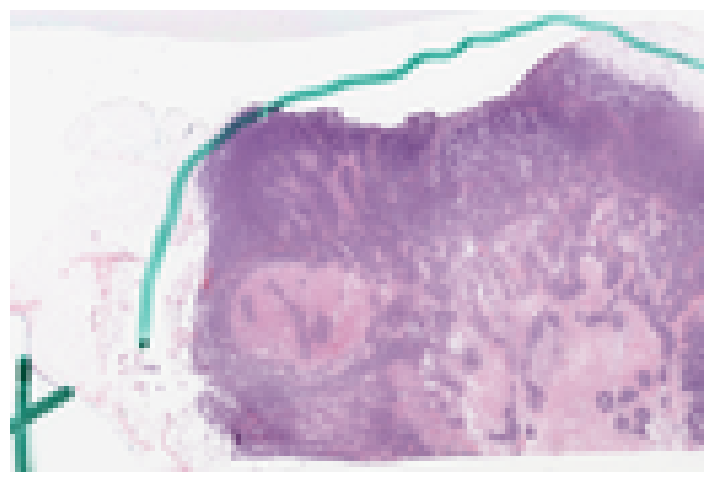

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

plt.imshow(thumbnail)
plt.axis("off")
plt.show()


